In [ ]:
# paquetes
import gymnasium as gym
import mo_gymnasium as mo_gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.utils as utils
from gymnasium.wrappers import RecordVideo

In [ ]:
env_id = "mo-lunar-lander-v3"
class DSLunar(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs_next, r_vec, term, trunc, info = self.env.step(action)
        done = term or trunc
        x_pos = obs_next[0]
        vy = obs_next[3]
        bonus_x = max(0.0, 1.0 - abs(x_pos)/1.0)
        bonus_v = max(0.0, 1.0 - abs(vy)/1.0)
        f1 = r_vec[0] + 0.05 * bonus_x + 0.05 * bonus_v
        
        f2 = -0.3 if action == 2 else 0.0
        f3 = -0.1 if action == 1 else 0.0
        f4 = -0.1 if action == 3 else 0.0
        multi_r = np.array([f1, f2, f3, f4], dtype=np.float32)
        return obs_next, multi_r, term, trunc, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs, info

In [ ]:
# política
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, act_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return F.softmax(logits, dim=-1)

In [ ]:
# retornos descontados multiobjetivo
def compute_discounted_returns(rewards, gamma):
    T, m = rewards.shape
    returns = np.zeros_like(rewards, dtype=np.float32)
    for j in range(m):
        running = 0.0
        for t in reversed(range(T)):
            running = rewards[t, j] + gamma * running
            returns[t, j] = running
    return returns

In [ ]:
# ejecución de episodios
def run_episode(env, policy, device):
    obs, _ = env.reset()
    obs = torch.from_numpy(obs).float().to(device)
    done = False
    log_probs, rewards, entropies = [], [], []
    while not done:
        probs = policy(obs)
        m = Categorical(probs)
        a = m.sample()
        log_probs.append(m.log_prob(a))
        entropies.append(-(probs * torch.log(probs + 1e-8)).sum())
        obs_next, r_vec, term, trunc, _ = env.step(a.item())
        rewards.append(r_vec)
        done = term or trunc
        obs = torch.from_numpy(obs_next).float().to(device)
    return log_probs, np.array(rewards, dtype=np.float32), entropies

Ep 1: Obj1=-95.42, Baseline=-0.67
Ep 2: Obj1=-94.43, Baseline=-1.32
Ep 3: Obj1=-95.92, Baseline=-1.98
Ep 4: Obj1=-95.63, Baseline=-2.64
Ep 5: Obj1=-92.78, Baseline=-3.18
Ep 6: Obj1=-95.44, Baseline=-3.84
Ep 7: Obj1=-95.59, Baseline=-4.49
Ep 8: Obj1=-92.85, Baseline=-5.04
Ep 9: Obj1=-92.09, Baseline=-5.57
Ep 10: Obj1=-95.96, Baseline=-6.21
Ep 11: Obj1=-94.28, Baseline=-6.75
Ep 12: Obj1=-92.13, Baseline=-7.22
Ep 13: Obj1=-94.44, Baseline=-7.77
Ep 14: Obj1=-95.52, Baseline=-8.34
Ep 15: Obj1=-92.47, Baseline=-8.82
Ep 16: Obj1=-93.64, Baseline=-9.34
Ep 17: Obj1=-90.87, Baseline=-9.78
Ep 18: Obj1=-96.23, Baseline=-10.34
Ep 19: Obj1=-96.49, Baseline=-10.94
Ep 20: Obj1=-95.70, Baseline=-11.51
Ep 21: Obj1=-95.37, Baseline=-12.07
Ep 22: Obj1=-93.82, Baseline=-12.58
Ep 23: Obj1=-96.03, Baseline=-13.13
Ep 24: Obj1=-96.45, Baseline=-13.70
Ep 25: Obj1=-95.19, Baseline=-14.21
Ep 26: Obj1=-96.06, Baseline=-14.76
Ep 27: Obj1=-95.65, Baseline=-15.30
Ep 28: Obj1=-92.57, Baseline=-15.70
Ep 29: Obj1=-95.07

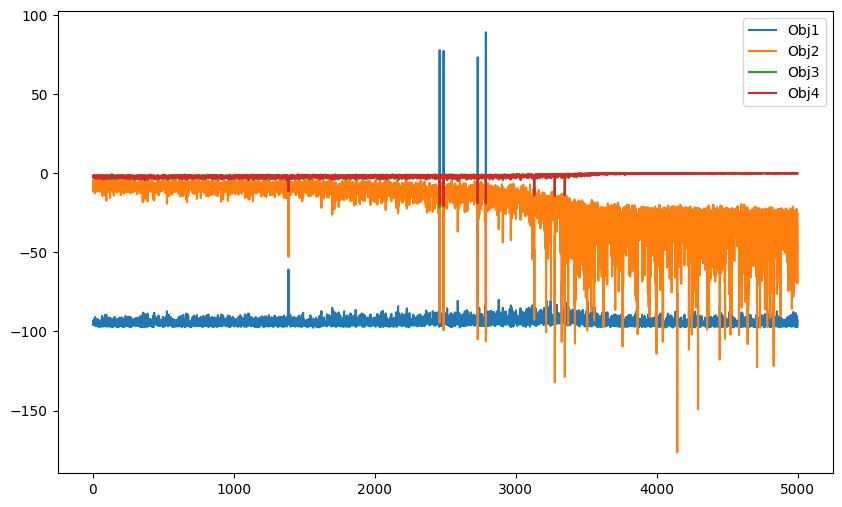

Video guardado en ./videos/top1_score89
Video guardado en ./videos/top2_score77
Video guardado en ./videos/top3_score77


In [ ]:
# entrenamiento principal
def main():
    # hiperparámetros
    num_episodes = 5000
    gamma = 0.99
    lr = 5e-4
    beta_entropy = 0.01
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    base_env = mo_gym.make(env_id, render_mode='rgb_array')
    env = DSLunar(base_env)

    obs_dim = base_env.observation_space.shape[0]
    act_dim = base_env.action_space.n
    policy = PolicyNetwork(obs_dim, act_dim).to(device)

    w = torch.tensor([0.6, 0.2, 0.1, 0.1], device=device)
    eps = 1e-8

    top_k = 3
    top_policies = []  

    episode_rewards = []
    baseline = 0.0
    alpha_baseline = 0.01

    for ep in range(num_episodes):
        log_probs, rewards, entropies = run_episode(env, policy, device)
        total1 = rewards.sum(axis=0)[0]
        episode_rewards.append(rewards.sum(axis=0))

        returns = compute_discounted_returns(rewards, gamma)
        baseline += alpha_baseline * (returns[:, 0].mean() - baseline)

        grads = []
        for j in range(4):
            ret_j = torch.tensor(returns[:, j], device=device)
            loss_j = sum(-lp * r for lp, r in zip(log_probs, ret_j))
            grad_j = torch.autograd.grad(loss_j, policy.parameters(), retain_graph=True)
            grads.append(utils.parameters_to_vector(grad_j))

        grad_ent = torch.autograd.grad(-beta_entropy * sum(entropies), policy.parameters())
        grad_ent_vec = utils.parameters_to_vector(grad_ent)

        d = torch.zeros_like(grads[0], device=device)
        for j, g in enumerate(grads):
            d -= w[j] * (g / (g.norm() + eps))
        d += grad_ent_vec

        with torch.no_grad():
            theta_vec = utils.parameters_to_vector(policy.parameters())
            theta_vec += lr * d
            utils.vector_to_parameters(theta_vec, policy.parameters())

        print(f"Ep {ep+1}: Obj1={total1:.2f}, Baseline={baseline:.2f}")

        if total1 > 0:
            theta_copy = theta_vec.cpu().clone()
            top_policies.append((total1, theta_copy))
            top_policies = sorted(top_policies, key=lambda x: x[0], reverse=True)[:top_k]

    rewards_arr = np.vstack(episode_rewards)
    plt.figure(figsize=(10,6))
    for i in range(rewards_arr.shape[1]):
        plt.plot(rewards_arr[:, i], label=f"Obj{i+1}")
    plt.legend(); plt.show()

    for idx, (score, theta_vec) in enumerate(top_policies, start=1):
       
        utils.vector_to_parameters(theta_vec.to(device), policy.parameters())
        vid_env = mo_gym.make(env_id, render_mode='rgb_array')
        wrapped = RecordVideo(vid_env, f'./videos/top{idx}_score{int(score)}', episode_trigger=lambda eid: eid==0)
        obs, _ = wrapped.reset()
        done = False
        while not done:
            a = torch.argmax(policy(torch.from_numpy(obs).float().to(device))).item()
            obs, _, term, trunc, _ = wrapped.step(a)
            done = term or trunc
        wrapped.close()
        print(f"Video guardado en ./videos/top{idx}_score{int(score)}")

if __name__ == '__main__':
    main()
